In [ ]:
# Copyright 2022 Intrinsic Innovation LLC.
# Copyright 2024 DeepMind Technologies Limited.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In this notebook, we explain how to use PGMax to run MAP inference on a 4-connected 2D Ising model.

In [ ]:
# # Uncomment this block if running on colab.research.google.com
# !pip install git+https://github.com/deepmind/PGMax.git

We start by making some necessary imports.

The [`pgmax.fgraph`](https://pgmax.readthedocs.io/en/latest/api.html#module-pgmax.fgraph) module contains classes for specifying factor graphs, the [`pgmax.vgroup`](https://pgmax.readthedocs.io/en/latest/api.html#module-pgmax.vgroup) module contains classes for specifying groups of variables, the [`pgmax.fgroup`](https://pgmax.readthedocs.io/en/latest/api.html#module-pgmax.fgroup) module contains classes for specifying groups of factors and the [`pgmax.infer`](https://pgmax.readthedocs.io/en/latest/api.html#module-pgmax.infer) module contains functions to run Loopy Belief Propagation (LBP).

In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

############
# Load PGMax
from pgmax import fgraph, fgroup, infer, vgroup

### Construct the variable group, initialize the factor graph, and add factors to it

We consider a 4-connected 2D Ising model where 2500 binary variables are arranged on a 50x50 2D grid. A pairwise factor connects each variable with its 4 grid neighbors.

The 4x4 version of this model looks as follows. Each arrow indicates the presence of a pairwise factor connecting two variables.

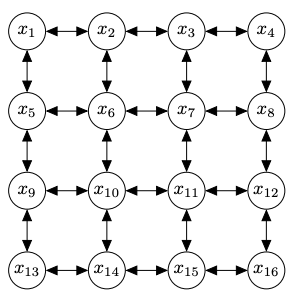








To create this model in PGMax, we first use [`NDVarArray`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.vgroup.NDVarArray), a convenient class for specifying a group of variables living on a multidimensional grid with possibly different number of states.

This class shares some similarities with [`numpy.ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), in particular regarding variables indexing.

In [ ]:
# Create the variable group
variables = vgroup.NDVarArray(num_states=2, shape=(50, 50))

Second, we initialize the [`FactorGraph`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgraph.FactorGraph) `fg` with the set of defined [`VarGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.vgroup.VarGroup)s. Once initialized, the set of variables in `fg` is fixed and cannot be changed.

In [ ]:
# Initialize the factor graph
fg = fgraph.FactorGraph(variable_groups=variables)

After initialization, `fg` does not have any factors. PGMax implements convenient and computationally efficient [`FactorGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgroup.FactorGroup) for representing groups of similar [`Factor`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.factor.Factor)s. We create the pairwise factors using the [`PairwiseFactorGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgroup.PairwiseFactorGroup) classes, before adding them to the factor graph.

Note that a [`FactorGroup`](https://pgmax.readthedocs.io/en/latest/api.html#pgmax.fgroup.FactorGroup) takes as argument (a) `variables_for_factors` which is a list of lists of the variables involved in the different factors, and (b) additional specific arguments (e.g. `log_potential_matrix` here).

In [ ]:
# Create the pairwise factor group
variables_for_factors = []
for ii in range(50):
  for jj in range(50):
    kk = (ii + 1) % 50
    ll = (jj + 1) % 50
    variables_for_factors.append([variables[ii, jj], variables[kk, jj]])
    variables_for_factors.append([variables[ii, jj], variables[ii, ll]])

factor_group = fgroup.PairwiseFactorGroup(
    variables_for_factors=variables_for_factors,
    log_potential_matrix=0.8 * np.array([[1.0, -1.0], [-1.0, 1.0]]),
)

# Add the pairwise factors to the factor graph
fg.add_factors(factor_group)

### Run inference

PGMax adopts a functional interface for running LBP.

We first need to create the LBP functions from the factor graph as follows.

In [ ]:
bp = infer.build_inferer(fg.bp_state, backend="bp")

The arguments of `bp` are several useful functions to run LBP:
 - `bp.init` initializes the arrays of factor `log_potentials`, of factor-to-variable messages (`ftov_msgs`) and of additional unary potentials (`evidence`)
 - `bp.run` or `bp.run_with_diffs` runs LBP inference
 - `bp.get_beliefs` computes the variable beliefs

To sample from the Ising model, we use the recently proposed [perturb-and-max-product (PMP)](https://proceedings.neurips.cc/paper/2021/hash/07b1c04a30f798b5506c1ec5acfb9031-Abstract.html) method, which estimates the maximum-a-posteriori (MAP) configuration (using max-product LBP) of a perturbed version of the model.

To this end, we use the `evidence_updates` argument of `bp.init` to perturb the model by adding Gumbel unary potentials.

In [ ]:
# Update the evidence
rng = jax.random.PRNGKey(0)
evidence_updates={variables: jax.random.gumbel(rng, shape=(50, 50, 2))}

# Run MAP inference
inferer_arrays = bp.init(evidence_updates=evidence_updates)
inferer_arrays, msgs_deltas = bp.run_with_diffs(inferer_arrays, num_iters=3000, temperature=0)

# Compute the beliefs
beliefs = bp.get_beliefs(inferer_arrays)

### Visualize the decoding and compute its energy

We first derive the MAP states from the beliefs

PGMax can also compute the energy of a decoding.

In [ ]:
# Get the MAP states
map_states = infer.decode_map_states(beliefs)

# Compute the energy of the decoding
decoding_energy = (
    infer.compute_energy(fg.bp_state, inferer_arrays, map_states)[0]
)
print("The energy of the decoding is", decoding_energy)

# Plot the image
img = map_states[variables]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(img)

### Monitor BP convergence

`bp.run_with_diffs` returns the maximum absolute difference of the messages between two consecutive iterations, which is used to monitor the (unguaranteed) convergence of LBP.

In [ ]:
assert np.max(msgs_deltas[-10:]) < 1e-3

plt.figure(figsize=(6, 4))
plt.plot(msgs_deltas)
plt.title("Max-product convergence", fontsize=18)
plt.xlabel("BP iteration", fontsize=16)
plt.ylabel("Max abs msgs diff", fontsize=16)